Group: Ctrl+Defeat

   

Assumption

The larger the daily price range, the more volatile the market is. High volatility may indicate uncertainty, fear, or transition periods between market regimes. (higher price - lower price)

Hypothesis

Load Data, Check Data whether is null or not

In [49]:
!pip install cybotrade_datasource
!pip install python-dotenv

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')

'''
async def main():
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic='cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour', 
        start_time=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
        end_time=datetime(year=2025, month=1, day=1, tzinfo=timezone.utc)
    )
    df = pd.DataFrame(data)
    print(df)
    

await main()
'''

'''
async def main():
    stream = await cybotrade_datasource.stream(
        api_key=API_KEY,
        topics=[
            'cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour',
            'cryptoquant|btc/market-data/liquidations?exchange=deribit&window=min',
        ],
    )
    async for msg in stream:
        print(msg)
    

await main()
'''

global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743682800000  82810.9  82862.1  82803.4  82849.9   72.958
1     1743682860000  82800.1  82845.3  82774.2  82810.9  190.549
2     1743682920000  82787.9  82833.0  82757.1  82800.1  115.033
3     1743682980000  82719.9  82802.5  82715.5  82787.9   86.747
4     1743683040000  82700.1  82736.0  82700.1  82719.9   69.310
...             ...      ...      ...      ...      ...      ...
9995  1744282500000  81642.1  81642.1  81613.9  81621.1   14.268
9996  1744282560000  81647.7  81660.6  81620.0  81642.1   31.397
9997  1744282620000  81714.2  81714.3  81641.9  81647.7   24.937
9998  1744282680000  81730.7  81730.8  81700.0  81714.2   29.491
9999  1744282

Display first five column of the dataframe

In [50]:
print(global_df)

         start_time    close     high      low     open   volume
0     1743682800000  82810.9  82862.1  82803.4  82849.9   72.958
1     1743682860000  82800.1  82845.3  82774.2  82810.9  190.549
2     1743682920000  82787.9  82833.0  82757.1  82800.1  115.033
3     1743682980000  82719.9  82802.5  82715.5  82787.9   86.747
4     1743683040000  82700.1  82736.0  82700.1  82719.9   69.310
...             ...      ...      ...      ...      ...      ...
9995  1744282500000  81642.1  81642.1  81613.9  81621.1   14.268
9996  1744282560000  81647.7  81660.6  81620.0  81642.1   31.397
9997  1744282620000  81714.2  81714.3  81641.9  81647.7   24.937
9998  1744282680000  81730.7  81730.8  81700.0  81714.2   29.491
9999  1744282740000  81720.5  81730.8  81720.5  81730.7   12.913

[10000 rows x 6 columns]


Analyze Data (first five and last five)

In [51]:
global_df.head()

,start_time,close,high,low,open,volume
0,1743682800000,82810.9,82862.1,82803.4,82849.9,72.958
1,1743682860000,82800.1,82845.3,82774.2,82810.9,190.549
2,1743682920000,82787.9,82833.0,82757.1,82800.1,115.033
3,1743682980000,82719.9,82802.5,82715.5,82787.9,86.747
4,1743683040000,82700.1,82736.0,82700.1,82719.9,69.310


In [52]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,1744282500000,81642.1,81642.1,81613.9,81621.1,14.268
9996,1744282560000,81647.7,81660.6,81620.0,81642.1,31.397
9997,1744282620000,81714.2,81714.3,81641.9,81647.7,24.937
9998,1744282680000,81730.7,81730.8,81700.0,81714.2,29.491
9999,1744282740000,81720.5,81730.8,81720.5,81730.7,12.913


In [53]:
global_df.shape

(10000, 6)

In [54]:
num_rows = len(global_df)
print(num_rows)

10000


We had 10000 rows in this dataset (latest)

In [55]:
cat_cols = global_df.select_dtypes(include=['object']).columns
num_cols = global_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index([], dtype='object')
Numerical Variables:
['start_time', 'close', 'high', 'low', 'open', 'volume']


In [56]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_time  10000 non-null  int64  
 1   close       10000 non-null  float64
 2   high        10000 non-null  float64
 3   low         10000 non-null  float64
 4   open        10000 non-null  float64
 5   volume      10000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 468.9 KB


Obtain a statistical summary of the dataframe using describe

In [57]:
global_df.describe()

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.743983e+12,80772.798970,80821.547290,80725.567140,80772.911910,117.280415
std,1.732137e+08,2669.165079,2651.928404,2686.202201,2669.229076,205.646963
min,1.743683e+12,74584.200000,74702.500000,74456.200000,74584.200000,0.946000
25%,1.743833e+12,78393.050000,78466.475000,78304.550000,78393.050000,25.845250
50%,1.743983e+12,81956.500000,81999.900000,81906.900000,81957.650000,59.004000
75%,1.744133e+12,83017.725000,83044.150000,82993.525000,83017.725000,130.400250
max,1.744283e+12,84670.200000,84736.000000,84656.100000,84670.200000,4595.508000


In [58]:
global_df.describe(include='all')

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.743983e+12,80772.798970,80821.547290,80725.567140,80772.911910,117.280415
std,1.732137e+08,2669.165079,2651.928404,2686.202201,2669.229076,205.646963
min,1.743683e+12,74584.200000,74702.500000,74456.200000,74584.200000,0.946000
25%,1.743833e+12,78393.050000,78466.475000,78304.550000,78393.050000,25.845250
50%,1.743983e+12,81956.500000,81999.900000,81906.900000,81957.650000,59.004000
75%,1.744133e+12,83017.725000,83044.150000,82993.525000,83017.725000,130.400250
max,1.744283e+12,84670.200000,84736.000000,84656.100000,84670.200000,4595.508000


In [59]:
num_rows = global_df.shape[0]
num_cols = global_df.shape[1]
print("Rows: ", num_rows, "Columns: ", num_cols)


Rows:  10000 Columns:  6


Show columns's data types using the property df.dtypes

In [60]:
global_df.dtypes

start_time      int64
close         float64
high          float64
low           float64
open          float64
volume        float64
dtype: object

In [61]:
summary_stats = global_df.describe()
print(summary_stats)

         start_time         close          high           low          open  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000  10000.000000   
mean   1.743983e+12  80772.798970  80821.547290  80725.567140  80772.911910   
std    1.732137e+08   2669.165079   2651.928404   2686.202201   2669.229076   
min    1.743683e+12  74584.200000  74702.500000  74456.200000  74584.200000   
25%    1.743833e+12  78393.050000  78466.475000  78304.550000  78393.050000   
50%    1.743983e+12  81956.500000  81999.900000  81906.900000  81957.650000   
75%    1.744133e+12  83017.725000  83044.150000  82993.525000  83017.725000   
max    1.744283e+12  84670.200000  84736.000000  84656.100000  84670.200000   

             volume  
count  10000.000000  
mean     117.280415  
std      205.646963  
min        0.946000  
25%       25.845250  
50%       59.004000  
75%      130.400250  
max     4595.508000  


Data Cleaning


In [62]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-03 12:20:00
1    2025-04-03 12:21:00
2    2025-04-03 12:22:00
3    2025-04-03 12:23:00
4    2025-04-03 12:24:00
...                  ...
9995 2025-04-10 10:55:00
9996 2025-04-10 10:56:00
9997 2025-04-10 10:57:00
9998 2025-04-10 10:58:00
9999 2025-04-10 10:59:00

[10000 rows x 1 columns]


In [63]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-03 12:20:00,82810.9,82862.1,82803.4,82849.9,72.958
1,2025-04-03 12:21:00,82800.1,82845.3,82774.2,82810.9,190.549
2,2025-04-03 12:22:00,82787.9,82833.0,82757.1,82800.1,115.033
3,2025-04-03 12:23:00,82719.9,82802.5,82715.5,82787.9,86.747
4,2025-04-03 12:24:00,82700.1,82736.0,82700.1,82719.9,69.310


In [64]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,2025-04-10 10:55:00,81642.1,81642.1,81613.9,81621.1,14.268
9996,2025-04-10 10:56:00,81647.7,81660.6,81620.0,81642.1,31.397
9997,2025-04-10 10:57:00,81714.2,81714.3,81641.9,81647.7,24.937
9998,2025-04-10 10:58:00,81730.7,81730.8,81700.0,81714.2,29.491
9999,2025-04-10 10:59:00,81720.5,81730.8,81720.5,81730.7,12.913


In [65]:
print(global_df)

              start_time    close     high      low     open   volume
0    2025-04-03 12:20:00  82810.9  82862.1  82803.4  82849.9   72.958
1    2025-04-03 12:21:00  82800.1  82845.3  82774.2  82810.9  190.549
2    2025-04-03 12:22:00  82787.9  82833.0  82757.1  82800.1  115.033
3    2025-04-03 12:23:00  82719.9  82802.5  82715.5  82787.9   86.747
4    2025-04-03 12:24:00  82700.1  82736.0  82700.1  82719.9   69.310
...                  ...      ...      ...      ...      ...      ...
9995 2025-04-10 10:55:00  81642.1  81642.1  81613.9  81621.1   14.268
9996 2025-04-10 10:56:00  81647.7  81660.6  81620.0  81642.1   31.397
9997 2025-04-10 10:57:00  81714.2  81714.3  81641.9  81647.7   24.937
9998 2025-04-10 10:58:00  81730.7  81730.8  81700.0  81714.2   29.491
9999 2025-04-10 10:59:00  81720.5  81730.8  81720.5  81730.7   12.913

[10000 rows x 6 columns]


In [66]:
global_df.dtypes

start_time    datetime64[ns]
close                float64
high                 float64
low                  float64
open                 float64
volume               float64
dtype: object

In [67]:
global_df.isnull().sum()

start_time    0
close         0
high          0
low           0
open          0
volume        0
dtype: int64

Percentage of missing value

In [68]:
(global_df.isnull().sum()/(len(global_df)))*100

start_time    0.0
close         0.0
high          0.0
low           0.0
open          0.0
volume        0.0
dtype: float64

Check duplicate value

In [69]:
global_df.count()

start_time    10000
close         10000
high          10000
low           10000
open          10000
volume        10000
dtype: int64

In [70]:
global_df.nunique()

start_time    10000
close          8883
high           8515
low            8469
open           8883
volume         9768
dtype: int64

In [71]:
duplicate_rows = global_df.duplicated()

# Display rows with duplicates
duplicate_rows_df = global_df[duplicate_rows]
print(duplicate_rows_df)

Empty DataFrame
Columns: [start_time, close, high, low, open, volume]
Index: []


In [72]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-03 12:20:00,82810.9,82862.1,82803.4,82849.9,72.958
1,2025-04-03 12:21:00,82800.1,82845.3,82774.2,82810.9,190.549
2,2025-04-03 12:22:00,82787.9,82833.0,82757.1,82800.1,115.033
3,2025-04-03 12:23:00,82719.9,82802.5,82715.5,82787.9,86.747
4,2025-04-03 12:24:00,82700.1,82736.0,82700.1,82719.9,69.310


Exploratory Data Analysis

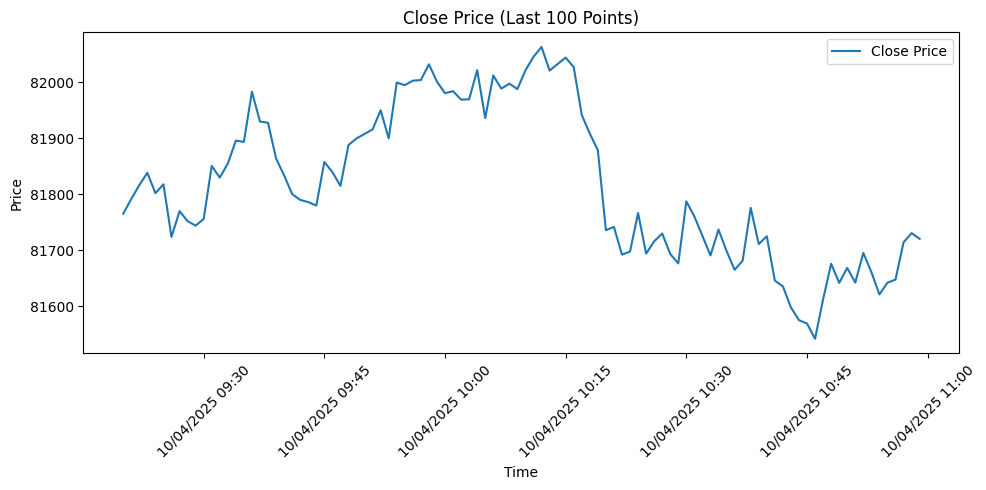

In [73]:
from matplotlib.dates import DateFormatter

# Convert your time column
global_df['start_time'] = pd.to_datetime(global_df['start_time'])

# Get last 100 rows
df_last = global_df.tail(100)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_last['start_time'], df_last['close'], label='Close Price')

# Set custom date format
date_fmt = DateFormatter('%d/%m/%Y %H:%M')  # Example: 10/04/2025 07:45
ax.xaxis.set_major_formatter(date_fmt)

# Labeling
ax.set_title('Close Price (Last 100 Points)')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Uptrend (approx. 09:25–09:45): The price shows a gradual and consistent increase, suggesting positive market sentiment or buying pressure.

Volatility Phase (approx. 09:45–10:00): Sharp up and down fluctuations in close price. This often suggests indecision, possible news events, or liquidity imbalances.

Downtrend (approx. 10:00–10:30): Clear and sharp drop in price.
May signal profit-taking, bearish sentiment, or reversal of earlier gains.

Mild Recovery (approx. 10:30–11:00): After hitting a low, price slightly rises again. Indicates attempt to regain confidence, but still uncertain.